In [0]:
! pip install sacremoses

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
#from utils.sensation_config import *
import numpy as np
# import argparse
# import logging
import pickle
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
from google.colab import drive
from tqdm import tqdm
drive.mount('/content/drive')
#from utils.global_variables import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dataset = '/content/drive/My Drive/dataset/dataset'

# Set hyperparameters 
Fine-tuned in optimization.ipynb.

In [0]:
# Hyper Parameters
batch_size = 50
sequence_length = 61
embedding_dim = 300
num_epoch = 5
num_layers = 1
num_classes = 2
bidirectional = True

In [0]:
# From optimization.ipynb
lr = 0.001 
hidden_dim = 150
dropout = 0.0

# Load GloVe

In [0]:
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2020-05-12 00:21:55--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 108.177.119.139, 108.177.119.101, 108.177.119.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9rrkuhhgpubkinbe494n6u9ob89krv90/1589242875000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2020-05-12 00:22:00--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9rrkuhhgpubkinbe494n6u9ob89krv90/1589242875000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|108.17

In [0]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
glove_path = "glove.6B.300d__50k.txt"

vocab, embeddings = load_glove(glove_path, embedding_dim)

# Process data 
Shuffling (random seed: 100) and splitting the dataset. No need to run again, files saved as scorer_dataset.pickle (also separate train, val and test files) and generation_dataset.pickle.

In [0]:
# Load pickle files
def load_from_pickle(data_path, label_path):
    pickle_dataset = open(data_path, 'rb')
    preprocessed_dataset = pickle.load(pickle_dataset)
    pickle_dataset.close()
    pickle_labels = open(label_path,'rb')
    labels = pickle.load(pickle_labels)
    pickle_labels.close()
    new_dict = {}
    for a in tqdm(preprocessed_dataset):
        new_dict[a] = preprocessed_dataset[a]
        new_dict[a].update(labels[a])

    pd_dataset = pd.DataFrame(new_dict).transpose()
    return pd_dataset

dataset_one = load_from_pickle(dataset+'/preprocessed_new_val.pickle',dataset+'/ground-truth-val.pickle')
dataset_two = load_from_pickle(dataset+'/preprocessed_new_train.pickle', dataset+'/ground-truth-train.pickle')
dataset_combined = pd.concat([dataset_one,dataset_two])

# 1 - hyperpartisan, 0 - non-hyperpartisan
dataset_combined['hyperpartisan'].replace('true',1,inplace=True)
dataset_combined['hyperpartisan'].replace('false',0,inplace=True)

# Split dataset into two halves - one for hyperpartisan scorer, one for headline generation

# Shuffle; random seed: 100
dataset_combined_shuffled = dataset_combined.sample(frac=1,random_state = 100)

# Split in half
scorer_dataset = dataset_combined_shuffled[:int(dataset_combined_shuffled.shape[0] * 0.5)]
generation_dataset = dataset_combined_shuffled[int(dataset_combined_shuffled.shape[0] * 0.5):]
# scorer_dataset.to_pickle(dataset+'/scorer_dataset.pickle')
# generation_dataset.to_pickle(dataset+'/generation_dataset.pickle')

In [0]:
scorer_train = pd.read_pickle(dataset+'/scorer_train.pickle')
scorer_test = pd.read_pickle(dataset+'/scorer_test.pickle')

In [0]:
# Split scorer dataset into 0.8 train, 0.05 val and 0.15 test
def split_dataset(dataset):
    train_size = int(dataset.shape[0]*0.8)
    val_size = int(dataset.shape[0]*0.05)
    
    train_df = dataset[:train_size]
    val_df = dataset[train_size:train_size+val_size]
    test_df = dataset[train_size+val_size:]
    return train_df, val_df, test_df

scorer_train, scorer_val, scorer_test = split_dataset(scorer_dataset)

In [0]:
# Extract only titles for the scorer
scorer_train_texts, scorer_train_labels = list(scorer_train.title), list(scorer_train.hyperpartisan)
scorer_val_texts, scorer_val_labels = list(scorer_val.title), list(scorer_val.hyperpartisan)
scorer_test_texts, scorer_test_labels = list(scorer_test.title), list(scorer_test.hyperpartisan)

In [0]:
# scorer_train_texts[:10]

# Featurize data

In [0]:
# Load pickle files
scorer_train = pd.read_pickle(dataset+'/scorer_train.pickle')
scorer_test = pd.read_pickle(dataset+'/scorer_test.pickle')
train_texts, train_labels = list(scorer_train.title), list(scorer_train.hyperpartisan)
test_texts, test_labels = list(scorer_test.title), list(scorer_test.hyperpartisan)

In [0]:
# Featurize data
def featurize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm(data):
        tokenized = tokenizer.tokenize(ex)
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels

tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = featurize(train_texts, train_labels, tokenizer, vocab)
test_data_indices, test_labels = featurize(test_texts, test_labels, tokenizer, vocab)

100%|██████████| 56250/56250 [00:08<00:00, 6253.89it/s]


# Create DataLoaders

In [0]:
# Create DataLoaders
class HyperpartisanDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_list, target_list, sequence_length):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.sequence_length = sequence_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, sequence_length=None):
        """
        Triggered when you call dataset[i]
        """
        if sequence_length is None:
            sequence_length = self.sequence_length
        token_idx = self.data_list[key][:sequence_length]
        label = self.target_list[key]
        return [token_idx, label]

    def collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] # store padded sequences
        label_list = []

        if len(max(self.data_list,key=len)) < self.sequence_length:
          max_batch_seq_len = len(max(self.data_list,key=len))
        else:
           max_batch_seq_len = self.sequence_length # the length of longest sequence in batch
                                                      # if it is less than self.sequence_length.
                                                      # else max_batch_seq_len = self.sequence_length 
        for row in batch:
          if len(row[0]) < max_batch_seq_len:
            row[0] += [0] * (max_batch_seq_len - len(row[0])) # pad the sequence with 0 if it's shorter than max_batch_seq_len
          row[0] = row[0][:self.sequence_length] # only trim the sequence longer than self.sequence_length
          data_list.append(row[0])
          label_list.append(row[1]) 
        data_list = torch.LongTensor(data_list)
        label_list = torch.LongTensor(label_list)

        return [data_list, label_list]

In [0]:
train_dataset = HyperpartisanDataset(train_data_indices, train_labels, sequence_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           collate_fn=train_dataset.collate_func,
                                           shuffle=False)

test_dataset = HyperpartisanDataset(test_data_indices, test_labels, sequence_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size,
                                           collate_fn=test_dataset.collate_func,
                                           shuffle=False)

In [0]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([50, 61])
data_batch:  tensor([[    2,  1664,   265,  ...,     0,     0,     0],
        [ 5863,   268,  3073,  ...,     0,     0,     0],
        [ 2505,  1872, 49553,  ...,     0,     0,     0],
        ...,
        [ 1525,  2392,     6,  ...,     0,     0,     0],
        [10470, 45292,    61,  ...,     0,     0,     0],
        [ 5367,    19,     2,  ...,     0,     0,     0]])
labels:  tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0])


# Create BiLSTM Model
Adapted from HW2. The architecture, BiLSTM with average pooling performs slightly better than the one in here https://github.com/chiyuzhang94/hyperpartisan-ubc/blob/master/pytorch/bilstm_optim.py, and that's what I used. However, the dataset with titles only is very noisy, so acc is not very high overall.

In [0]:
# Define BiLSTM Model
class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, embeddings, hidden_dim, num_layers, num_classes, bidirectional, dropout_prob):
        super().__init__()
        self.hidden_dim = hidden_dim
        # self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        # self.lstm = nn.LSTM( # LSTM layer
        #                     self.embedding_layer.embedding_dim,\
        #                     hidden_size = hidden_dim, \
        #                     num_layers = num_layers, \
        #                     bidirectional = bidirectional, \
        #                     batch_first = True,\
        #                     dropout=dropout_prob)
        # self.softmax = nn.LogSoftmax() 
        # self.dropout_layer = nn.Dropout(p=dropout_prob) # dropout some units of the hidden layer
        # self.hidden2out = nn.Linear(hidden_dim*(int(bidirectional)+1), num_classes) # classifier layer
        
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        
        self.dropout = dropout_prob
        self.lstm = nn.LSTM(self.embedding_layer.embedding_dim, hidden_size= self.hidden_dim, \
                            num_layers = num_layers, bidirectional = bidirectional, \
                            batch_first = True, dropout = self.dropout)
        self.non_linearity = nn.ReLU() # For example, ReLU
        self.clf = nn.Linear(self.hidden_dim*(int(bidirectional)+1), num_classes) # classifier layer

    def load_pretrained_embeddings(self, embeddings):
        """
           The code for loading embeddings from Lab 2
           Unlike lab, we are not setting `embedding_layer.weight.requires_grad = False`
           because we want to finetune the embeddings on our data
        """
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer
    
    def forward(self, inputs):

        # Embedding 
        # Output dim: [batch_size, seq_length, embedding_dim]
        embedded = self.embedding_layer(inputs)

        # BiLSTM
        # Output dim: [batch_size, seq_length, hidden_dim * num_directions]
        h_0 = torch.zeros(num_layers*(int(bidirectional)+1), inputs.size(0), int(self.hidden_dim))
        c_0 = torch.zeros(num_layers*(int(bidirectional)+1), inputs.size(0), int(self.hidden_dim))
        bilstm_out, _ = self.lstm(embedded, (h_0, c_0))
        
        # # Dropout layer
        # # Output dim: [batch_size, hidden_dim * num_directions]
        # dropout_out = self.dropout_layer(bilstm_out[:, -1, :])

        # # Get output from hidden states
        # # Output dim: [batch_size, num_classes]
        # linear_out = self.hidden2out(dropout_out)   
       
        # # Outputting using softmax layer
        # # Output dim: [batch_size, num_classes]
        # prob = self.softmax(linear_out)

        # return prob
               
        # Average pooling
        # Output dim: [batch_size, num_directions * hidden_size]
        num_valid = (inputs == (0 or 1)) \
            .float().sum(dim=1).clamp(1) # non-padding, non-unknown
        averaged_out = bilstm_out.sum(dim=1) / num_valid.view(-1, 1)
        
        # Non-linearity (ReLU)
        # Output dim: [num_directions * hidden_size , num_classes]
        non_linearity_out = self.non_linearity(averaged_out)

        # Linear, returns logits 
        # Output dim: [batch_size, num_classes]
        logits = self.clf(non_linearity_out)

        return logits


# Train
Adapted from https://github.com/chiyuzhang94/hyperpartisan-ubc/blob/master/pytorch/train.py

In [0]:
# Training
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, device):
    accuracy = None
    model.eval()
    with torch.no_grad():
      all_preds = []
      all_labels = []
      for batch_text, batch_labels in dataloader:
          preds = model(batch_text.to(device))
          all_preds.append(preds.detach().cpu().numpy())
          all_labels.append(batch_labels.detach().cpu().numpy())
      all_preds = np.concatenate(all_preds, axis=0)
      pred_labels = all_preds.argmax(-1)
      all_labels = np.concatenate(all_labels, axis=0)
      accuracy = accuracy_score(all_labels,pred_labels)

    return accuracy 

def train(num_epoch,\
          optimizer,\
          train_loader,\
          test_loader,
          model,\
          criterion,\
          device,\
          outpath):
   
    acc = 0
    train_loss = []
    train_acc = []
    test_acc = []
    print("training")
    for epoch in tqdm(range(num_epoch)):
        outfile = open(outpath+"/bilstm_train_output.txt",'a')

        # train the model and back-propagate by batch process
        for i, (data_batch, batch_labels) in enumerate(train_loader):
            preds = model(data_batch.to(device))
            loss = criterion(preds, batch_labels.to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.item())

        # get train accuracy for each epoch
        acc = evaluate(model, train_loader, device)
        print('Training Accuracy of the network on epoch %i: %f %%' % (epoch, acc*100))
        train_acc.append(acc)
        training_acc = acc

        # get test accuracy for each epoch
        acc = evaluate(model, test_loader, device)
        print('Testing Accuracy of the network on epoch %i: %f %%' % (epoch, acc*100))
        test_acc.append(acc)
        testing_acc = acc
        # save model afer each epoch
        if torch.cuda.device_count() <= 1:
            state_dict_model = model.state_dict()
        else:
            state_dict_model = model.module.state_dict()

        state = {
        'epoch': epoch,
        'state_dict': state_dict_model,
        'optimizer': optimizer.state_dict(),
        }
        
        torch.save(state, outpath+"/train_"+str(epoch)+".pt")

        outfile.write("Epoch: {}, Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}\n".format(epoch,training_acc,testing_acc))
        outfile.close()
    return train_loss, train_acc, test_acc

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
outpath = '/content/drive/My Drive/dataset/hyperpartisan_scorer/results'
criterion = nn.CrossEntropyLoss()

In [0]:
torch.cuda.is_available()

False

In [0]:
# Run
if torch.cuda.is_available():
    bilstm = LSTMClassifier(embeddings,hidden_dim = int(hidden_dim),num_layers = num_layers,num_classes = num_classes,dropout_prob=dropout,bidirectional = bidirectional).cuda()
else:
    bilstm = LSTMClassifier(embeddings,hidden_dim = int(hidden_dim),num_layers = num_layers,num_classes = num_classes,dropout_prob=dropout, bidirectional = bidirectional)
optimizer = torch.optim.Adam(bilstm.parameters(), lr=lr)   # define a optimizer for backpropagation
train_loss, train_acc, test_acc = train(num_epoch,optimizer,train_loader,test_loader,bilstm,criterion,device,outpath)
print(test_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

training
Training Accuracy of the network on epoch 0: 81.931333 %
Testing Accuracy of the network on epoch 0: 78.117333 %


 20%|██        | 1/5 [38:18<2:33:14, 2298.64s/it]

Training Accuracy of the network on epoch 1: 85.830333 %
Testing Accuracy of the network on epoch 1: 77.971556 %


 40%|████      | 2/5 [1:19:13<1:57:16, 2345.51s/it]

Training Accuracy of the network on epoch 2: 88.896333 %
Testing Accuracy of the network on epoch 2: 76.951111 %


 60%|██████    | 3/5 [1:58:39<1:18:23, 2351.59s/it]

Training Accuracy of the network on epoch 3: 90.828667 %
Testing Accuracy of the network on epoch 3: 76.135111 %


 80%|████████  | 4/5 [2:41:12<40:12, 2412.20s/it]  

Training Accuracy of the network on epoch 4: 92.220333 %
Testing Accuracy of the network on epoch 4: 75.502222 %


100%|██████████| 5/5 [3:23:18<00:00, 2439.66s/it]

[0.7811733333333334, 0.7797155555555556, 0.7695111111111111, 0.7613511111111111, 0.7550222222222223]


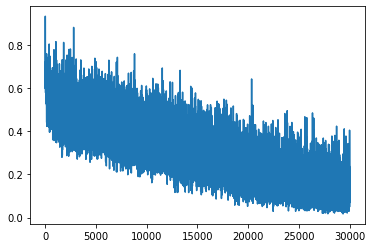

In [0]:
import matplotlib.pyplot as plt
plt.plot(pd.Series(train_loss))

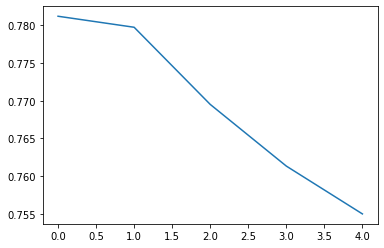

In [0]:
pd.Series(test_acc).plot()